In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from ggmodel_dev.graphmodel import GraphModel, concatenate_graph_specs
from ggmodel_dev.validation import score_model, plot_diagnostic, score_model_dictionnary

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables
from ggmodel_dev.models.landuse.BE2 import model_dictionnary

import pandas as pd
import numpy as np

# Model developement notebook

The goal of this notebook is to develop and improve the landuse model.

Remarks:

- comment 1
- comment 2
- comment 3

## Data

In [3]:
def prepare_landuse_model_data():

    df_tables = ['foodbalancesheet_new', 'population', 'crops', 'landuse']

    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    df_dictionnary['foodbalancesheet_new'] = df_dictionnary['foodbalancesheet_new'][~df_dictionnary['foodbalancesheet_new'].Variable.isin(['Domestic supply quantity'])]

    df_dictionnary['foodbalancesheet_new'] = df_dictionnary['foodbalancesheet_new'].drop(columns=['group']) # for now only crop is considered
    
    data_dict = data_dict_from_df_tables([df for _, df in df_dictionnary.items()])

    data_dict['CL_baseline'] = data_dict['CL']
    data_dict['IL_baseline'] = data_dict['IL']
    data_dict['FL_baseline'] = data_dict['FL']
    data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)
    data_dict['CL_corr_coef'] = pd.Series(data=1.4, index=data_dict['CL_baseline'].index)

    def preprocess_dict_item(key, value):

        return (
            value.fillna(0)
        )

    
    data_dict = {k: preprocess_dict_item(k, v) for k, v in data_dict.items()}
    data_dict['CYi'] = data_dict['CYi'].replace(0, np.nan)
    return data_dict

data_dict = prepare_landuse_model_data()

In [4]:
ISO_data_dict = {k: v.loc[['FRA', 'HUN', 'DEU', 'NLD', 'BEL', 'CHE', 'BRA', 'SEN'], [2016, 2017, 2018], :] for k, v in data_dict.items()}


## Model

In [5]:
scores = score_model_dictionnary(model_dictionnary, ISO_data_dict)

TCLDi_model: Done
TCLDi_partial_model: Done
FPi_model: Done
IL_FL_model: Done
BE2_partial_model: Error: No objects to concatenate
BE2_model: Done


In [6]:
scores['BE2_model']['score_by_Variable']

,r2,correlation,rmse
Variable,,,
CL,0.797699,0.995561,8.088528e+07
FL,0.996999,0.999990,8.038138e+07
FPi,0.043805,0.211274,4.472898e+08
IL,-5.329825,0.835806,4.779927e+05
TCLDi,0.932502,0.965834,2.458636e+11


## Scenario

In [7]:
from ggmodel_dev.projection import *
from ggmodel_dev.models.landuse import BE2_scenario


In [11]:
ISO = 'FRA'
data_dict_filtered = {k: v.loc[ISO, 2000:] for k, v in data_dict.items()}

list_of_scenarios = [dict(FDKGi_target=0.9, FLOi_target=0.8, CYi_target=1.1, R_rate=120),
                     dict(FDKGi_target=0.5, FLOi_target=0.5, CYi_target=1.1, R_rate=120),
                     dict(FDKGi_target=1.5, FLOi_target=1.5, CYi_target=1.1, R_rate=120)]

simulation_results = run_scenario_list(scenario_function=BE2_scenario.run_scenario,
                                       list_of_scenarios=list_of_scenarios,
                                       projection_dictionnary=BE2_scenario.projection_dict,
                                       data_dict=data_dict_filtered
                                      )

<AxesSubplot:xlabel='ISO,Year'>

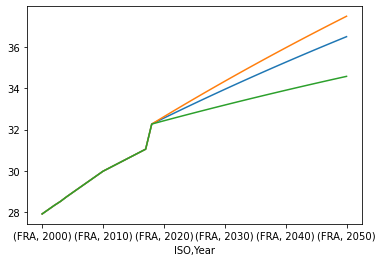

In [12]:
simulation_results['scenario_0']['BE2'].plot()
simulation_results['scenario_1']['BE2'].plot()
simulation_results['scenario_2']['BE2'].plot()